# <font color='#cec748'>This notebook is for SED fitting of our Chenxu AGN data</font>
The notebook uses data from the get_spec_example file to:
- Work with the spectra (make adjustments and clean up)
- Look at spectra over wavelength
- Fit spectral lines
- Find BH Mass

## <font color='#e55730' size=3 >Imports</font>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bagpipes as pipes

from astropy.table import QTable, Table, Column
import matplotlib as mpl

from astropy import units as u
from astropy.cosmology import Planck18
import os
from scipy.interpolate import interp1d
import warnings

import pandas as pd
from matplotlib.gridspec import GridSpec
import seaborn as sns

from matplotlib.ticker import ScalarFormatter

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

from scipy.stats import gaussian_kde

import nautilus

#import pymultinest
import dynesty
import ultranest
import emcee

Bagpipes: PyMultiNest import failed, fitting will use the Nautilus sampler instead.


## <font color='#e55730' size=3 >Plotting imports and settings</font>

## <font color='#e55730' size=3 >Values</font>

In [2]:
c = 299792.5 #km s^-1
H_0 = 70 #km s^-1 MpC^-1

"""
These are the rest wavelengths in angstroms for the lines that are important for the fits.
"""
HeII_2733 = 2733.289
MgII_2800 = 2799.000
FeIV_2829 = 2829.36
FeIV_2836 = 2835.740
ArIV_2854 = 2853.670
ArIV_2868 = 2868.210


"""
To get the FWHM to use in my MgII fitting in velocity space. 
This will give a minumum not a maximum.
FWHM = speed of light / spectral resolution.
"""
R = 800 #Spectral Resolution

FWHM_Velocity = c/R


# Your existing code should work better now
hsc_filter_files = {
    'hsc_g': '/home/jovyan/work/stampede3/AGN-Black-Hole-Research/hsc_g.dat',
    'hsc_r': '/home/jovyan/work/stampede3/AGN-Black-Hole-Research/hsc_r.dat', 
    'hsc_i': '/home/jovyan/work/stampede3/AGN-Black-Hole-Research/hsc_i.dat',
    'hsc_z': '/home/jovyan/work/stampede3/AGN-Black-Hole-Research/hsc_z.dat',
    'hsc_y': '/home/jovyan/work/stampede3/AGN-Black-Hole-Research/hsc_y.dat'
}

In [3]:
# How to figure out everything about the calls / definitions

"""
# Get the function's signature
signature = inspect.signature(ESU.stack_spectra)
print("Signature:", signature)

# Get the return type annotation
return_type = signature.return_annotation
print("Return type:", return_type)

# Get the docstring
docstring = inspect.getdoc(ESU.stack_spectra)
print("Docstring:", docstring)

# Get the source code
source_code = inspect.getsource(ESU.stack_spectra)
print("Source code:\n", source_code)
"""

'\n# Get the function\'s signature\nsignature = inspect.signature(ESU.stack_spectra)\nprint("Signature:", signature)\n\n# Get the return type annotation\nreturn_type = signature.return_annotation\nprint("Return type:", return_type)\n\n# Get the docstring\ndocstring = inspect.getdoc(ESU.stack_spectra)\nprint("Docstring:", docstring)\n\n# Get the source code\nsource_code = inspect.getsource(ESU.stack_spectra)\nprint("Source code:\n", source_code)\n'

'''
For plotting clear distinctions 

Teal - #309898 - Original teal base
Orange - #FF9F00 - Original orange base
Red - #CB0404 - Original red base
Black - #000000 - Original black base
Navy Blue - #1D5799 - Deep blue with good contrast against teal
Yellow - #ECC700 - Bright yellow distinguishable from orange
Purple - #8B3D88 - Distinct from blues and reds
Lime Green - #74B741 - Bright green distinguishable from teal
Magenta - #DB3EB1 - Distinct pink/purple
Brown - #8D6E42 - Earth tone distinct from oranges and reds




Sequential Teal Variants (for heatmaps or gradients)

Teal 100% - #309898 - Base teal
Teal 80% - #5CACA6 - Lighter teal
Teal 60% - #87BFB5 - Even lighter teal
Teal 40% - #B2D2CC - Very light teal
Teal 20% - #D9E6E3 - Almost white teal




Sequential Orange Variants (for heatmaps or gradients)

Orange 100% - #FF9F00 - Base orange
Orange 80% - #FFB440 - Lighter orange
Orange 60% - #FFC977 - Even lighter orange
Orange 40% - #FFDEA6 - Very light orange
Orange 20% - #FFF0D9 - Almost white orange




High Contrast Pairs
These pairs are specifically designed to be highly distinguishable from each other:

Vivid Blue - #0072B2 - ColorBrewer-inspired blue
Vivid Orange - #E69F00 - ColorBrewer-inspired orange
Vivid Green - #009E73 - ColorBrewer-inspired green
Vivid Red - #D55E00 - ColorBrewer-inspired red
Vivid Purple - #9467BD - ColorBrewer-inspired purple




Special Purpose

Background Gray - #F0F0F0 - Light gray for plot backgrounds
Grid Line Gray - #CCCCCC - Medium gray for grid lines
Highlight Yellow - #FFFB54 - Attention-grabbing highlight
Reference Line - #505050 - Dark gray for reference lines
Annotation Red - #E41A1C - Bright red for important annotations




colors = {
    '025_035': "#a714ff",  # Purple
    '035_045': "#ff14f5",  # Pink
    '045_055': "#14D8FF",  # Teal
    '055_065': "#60B5FF",  # Blue
    '065_075': "#00FF9C",  # Green
    '075_085': "#ffbb14",  # Orange
    '085_096': "#FF5757"   # Red

    
'''

## <font color='#e55730' size=3 >Definitions</font>

In [4]:
def create_bagpipes_data_loader_correct(flux_array, flux_err_array, redshift):
    """
    Create CORRECT data loader function for BAGPIPES photometry-only fitting
    
    Based on official BAGPIPES documentation:
    - For photometry-only: load_data should return ONLY photometry (not a tuple)
    - Photometry should be 2D array with shape (n_filters, 2)
    - Format: [[flux1, error1], [flux2, error2], ...]
    - Units: microjanskys (default for phot_units)
    
    Parameters:
    -----------
    flux_array : array-like
        Flux values in microjanskys
    flux_err_array : array-like
        Flux error values in microjanskys
    redshift : float
        Galaxy redshift (passed separately to galaxy object)
        
    Returns:
    --------
    function : Data loader function that returns correct format
    """
    
    def load_data(galaxy_id):
        """
        Load photometry data for BAGPIPES
        
        For photometry-only fitting, return only the photometry array
        Redshift is handled separately by the galaxy object
        """
        
        # Convert to numpy arrays and ensure they're 1D
        flux_arr = np.asarray(flux_array, dtype=np.float64).flatten()
        flux_err_arr = np.asarray(flux_err_array, dtype=np.float64).flatten()
        
        # Check arrays have same length
        if len(flux_arr) != len(flux_err_arr):
            raise ValueError(f"Flux and error arrays must have same length: {len(flux_arr)} vs {len(flux_err_arr)}")
        
        # Ensure positive fluxes and errors
        flux_arr = np.maximum(flux_arr, 1e-10)  # Avoid zero/negative fluxes
        flux_err_arr = np.maximum(flux_err_arr, 1e-10)  # Avoid zero/negative errors
        
        # Create 2D photometry array: each row is [flux, error] for one filter
        photometry_array = np.column_stack([flux_arr, flux_err_arr])
        
        # Verify shape and data types
        print(f"Data loader returning photometry with shape: {photometry_array.shape}")
        print(f"Data type: {photometry_array.dtype}")
        print(f"Sample values: {photometry_array[:2]}")
        
        # For photometry-only fitting, return ONLY the photometry array
        return photometry_array
    
    return load_data


def create_bagpipes_filter_files_corrected(filter_response_files, output_dir="bagpipes_filters"):
    """
    Create BAGPIPES-compatible filter files from HSC filter response curves
    
    Parameters:
    -----------
    filter_response_files : dict
        Dictionary mapping filter names to response curve file paths
    output_dir : str
        Directory to save BAGPIPES filter files
        
    Returns:
    --------
    tuple : (filter_file_paths_dict, filter_paths_list)
    """
    
    os.makedirs(output_dir, exist_ok=True)
    
    filter_file_paths = {}
    
    for filter_name, response_file_path in filter_response_files.items():
        
        if not os.path.exists(response_file_path):
            print(f"Warning: Filter file {response_file_path} not found, skipping {filter_name}")
            continue
        
        try:
            # Load filter response curve
            data = np.loadtxt(response_file_path)
            
            if data.shape[1] != 2:
                print(f"Warning: {response_file_path} should have 2 columns (wavelength, transmission)")
                continue
            
            wavelength = data[:, 0]  # Assuming already in Angstroms
            transmission = data[:, 1]
            
            # Create output filename
            output_filename = f"{filter_name}.filt"
            output_path = os.path.join(output_dir, output_filename)
            
            # Save in BAGPIPES format (wavelength in Angstroms, transmission fraction)
            bagpipes_data = np.column_stack([wavelength, transmission])
            np.savetxt(output_path, bagpipes_data, fmt='%.6e')
            
            filter_file_paths[filter_name] = output_path
            print(f"Created BAGPIPES filter file: {output_path}")
            
        except Exception as e:
            print(f"Error processing {filter_name}: {e}")
            continue
    
    # Create list of filter paths in consistent order
    filter_paths_list = [filter_file_paths[name] for name in sorted(filter_file_paths.keys())]
    
    return filter_file_paths, filter_paths_list

def check_bagpipes_dependencies():
    """
    Check which sampler is available and working - prioritizing dynesty
    
    Returns:
    --------
    str : "dynesty", "ultranest", "multinest", "emcee", or "none"
    """
    
    # Test dynesty first (recommended MultiNest alternative)
    try:
        print("✓ dynesty is available - excellent nested sampling alternative to MultiNest")
        return "dynesty"
    except ImportError:
        print("✗ dynesty not available")
    
    # Test UltraNest (another good nested sampling option)
    try:
        print("✓ ultranest is available - another nested sampling option")
        return "ultranest"
    except ImportError:
        print("✗ ultranest not available")
    
    # Test MultiNest (if properly installed)
    try:
        # Try to actually use it to see if the library is properly installed
        pymultinest.run(lambda: 0, lambda: 0, 1, n_live_points=2, resume=False, 
                      verbose=False, outputfiles_basename='test_', max_iter=1)
        print("✓ MultiNest is available and working")
        return "multinest"
    except Exception as e:
        print(f"✗ MultiNest installed but not working: {e}")
    
    # Test emcee (MCMC fallback)
    try:
        print("✓ emcee is available - MCMC sampler (different from nested sampling)")
        return "emcee"
    except ImportError:
        print("✗ emcee not available")
    
    # Test nautilus (last resort)
    try:
        print("✓ nautilus is available - will try with workarounds")
        return "nautilus"
    except ImportError:
        print("✗ nautilus not available")
    
    print("✗ No supported samplers available!")
    return "none"

def setup_bagpipes_model_minimal_stable(fixed_redshift=None):
    """
    Set up the most minimal stable BAGPIPES model
    
    Parameters:
    -----------
    fixed_redshift : float, optional
        If provided, fix redshift to this value
        
    Returns:
    --------
    dict : BAGPIPES model configuration
    """
    
    # Define minimal model components
    model_components = {}
    
    # Redshift - fixed or free
    if fixed_redshift is not None:
        model_components["redshift"] = fixed_redshift
    else:
        model_components["redshift"] = (0.299, 0.301)  # Conservative range
    
    # Star formation history - constant star formation rate (simplest)
    model_components["constant"] = {
        "age": (1.0, 13.0),          # Avoid very young ages
        "massformed": (9.0, 11.5),   # Narrow, realistic range
        "metallicity": (0.5, 1.5)    # Conservative metallicity range
    }
    
    return model_components

def setup_bagpipes_model_robust(fixed_redshift):
    """
    Set up a robust BAGPIPES model with dust for AGN research
    
    Parameters:
    -----------
    fixed_redshift : float, optional
        If provided, fix redshift to this value
        
    Returns:
    --------
    dict : BAGPIPES model configuration
    """
    
    # Define model components
    model_components = {}
    
    # Redshift - fixed or free
    if fixed_redshift is not None:
        model_components["redshift"] = fixed_redshift
    else:
        model_components["redshift"] = (0.29, 0.301)  # Avoid zero redshift
    
    # Star formation history - delayed exponential (tau model)
    model_components["delayed"] = {
        "age": (0.5, 13.0),          # Avoid very young ages
        "tau": (0.3, 5.0),           # More conservative tau range
        "massformed": (8.0, 12.0),   # Realistic stellar mass range
        "metallicity": (0.1, 2.0)    # Avoid extreme metallicities
    }
    
    # Dust attenuation - Calzetti law
    model_components["dust"] = {
        "type": "Calzetti",         # Calzetti dust law
        "Av": (0.0, 2.0)            # Conservative attenuation range
    }
    
    return model_components

def setup_bagpipes_model_agn_optimized(fixed_redshift=None):
    """
    Set up BAGPIPES model optimized for AGN host galaxy research
    
    Parameters:
    -----------
    fixed_redshift : float, optional
        If provided, fix redshift to this value
        
    Returns:
    --------
    dict : BAGPIPES model configuration
    """
    
    model_components = {}
    
    # Redshift
    if fixed_redshift is not None:
        model_components["redshift"] = fixed_redshift
    else:
        model_components["redshift"] = (0.299, 0.301)  # AGN can be at higher z
    
    # Double exponential SFH (good for AGN hosts with possible bursts)
    model_components["dblplaw"] = {
        "tau": (0.1, 3.0),           # e-folding time
        "alpha": (0.1, 1000.0),      # Power-law slope at early times
        "beta": (0.1, 1000.0),       # Power-law slope at late times
        "massformed": (8.5, 12.5),   # AGN hosts often massive
        "metallicity": (0.2, 2.5)    # AGN hosts can be metal-rich
    }
    
    # Dust - important for AGN hosts
    model_components["dust"] = {
        "type": "Calzetti",
        "Av": (0.0, 3.0)            # AGN hosts can be dusty
    }
    
    return model_components

def install_sampler_guide():
    """
    Print installation guide for supported samplers
    """
    
    print("\n" + "="*70)
    print("SAMPLER INSTALLATION GUIDE")
    print("="*70)
    print("\nRecommended installation order:")
    print("\n1. DYNESTY (BEST OPTION - direct MultiNest replacement):")
    print("   pip install dynesty")
    print("   - Pure Python nested sampling")
    print("   - No C library dependencies")
    print("   - Same algorithm family as MultiNest")
    print("\n2. ULTRANEST (Alternative nested sampling):")
    print("   pip install ultranest")
    print("   - Another excellent nested sampler")
    print("   - Good for high-dimensional problems")
    print("\n3. EMCEE (MCMC alternative):")
    print("   pip install emcee")
    print("   - Different approach (MCMC vs nested sampling)")
    print("   - Very reliable and widely used")
    print("\n4. MULTINEST (if you can get it working):")
    print("   conda install -c conda-forge multinest")
    print("   - Original nested sampling implementation")
    print("   - Requires C/Fortran compilation")
    print("\nFor AGN research, nested sampling (dynesty/ultranest) is recommended")
    print("over MCMC because it handles multi-modal posteriors better.")
    print("="*70)

def run_bagpipes_fit_dynesty_fixed(flux_array, flux_err_array, 
                                 filter_response_files, redshift, 
                                 n_live, galaxy_id="agn_galaxy",
                                 run_name="agn_fit",
                                 model_type="robust"):
    """
    BAGPIPES SED fitting with FIXED parameter compatibility for dynesty and other samplers
    
    This version uses only parameters that are universally supported across BAGPIPES versions
    
    Parameters:
    -----------
    flux_array : array-like
        Flux values in microjanskys for HSC filters
    flux_err_array : array-like  
        Flux error values in microjanskys for HSC filters
    filter_response_files : dict
        Dictionary mapping filter names to response curve file paths
    galaxy_id : str
        Galaxy identifier
    redshift : float
        Fixed spectroscopic redshift
    run_name : str
        Name for the fitting run
    n_live : int
        Number of live points for nested sampling
    model_type : str
        "minimal", "robust", or "agn_optimized"
        
    Returns:
    --------
    tuple : (fit, galaxy) BAGPIPES objects
    """
    
    print("BAGPIPES AGN Host Galaxy SED Fitting (Parameter-Fixed Version)")
    print("=" * 70)
    
    # Check available samplers
    sampler = check_bagpipes_dependencies()
    if sampler == "none":
        print("ERROR: No supported samplers available!")
        install_sampler_guide()
        return None, None
    
    # 1. Create BAGPIPES-compatible filter files
    print("\nCreating BAGPIPES-compatible filter files...")
    filter_file_paths, filter_paths_list = create_bagpipes_filter_files_corrected(
        filter_response_files, output_dir="bagpipes_filters"
    )
    
    if len(filter_file_paths) == 0:
        print("ERROR: No filter files created successfully!")
        return None, None
    
    print(f"Successfully created {len(filter_file_paths)} filter files")
    
    # 2. Create data loader function
    print("Creating data loader function...")
    load_data = create_bagpipes_data_loader_correct(flux_array, flux_err_array, redshift)
    
    # 3. Test the data loader
    print("Testing data loader...")
    try:
        test_photometry = load_data(galaxy_id)
        print(f"✓ Data loader test successful")
        print(f"  Photometry shape: {test_photometry.shape}")
        
        # Print photometry summary
        print(f"\nPhotometric data summary:")
        print("-" * 35)
        filter_names = sorted(filter_file_paths.keys())
        for i, filt_name in enumerate(filter_names):
            if i < len(test_photometry):
                flux, err = test_photometry[i]
                snr = flux / err if err > 0 else 0
                print(f"{filt_name:10s}: {flux:8.2f} ± {err:6.2f} μJy (S/N: {snr:5.1f})")
        
    except Exception as e:
        print(f"✗ Data loader test failed: {e}")
        return None, None
    
    # 4. Create galaxy object
    print(f"\nCreating galaxy object...")
    try:
        galaxy = pipes.galaxy(galaxy_id, 
                             load_data, 
                             spectrum_exists=False,
                             photometry_exists=True,
                             filt_list=filter_paths_list,
                             phot_units='mujy')
        
        print(f"✓ Galaxy object created successfully!")
        
    except Exception as e:
        print(f"✗ Galaxy object creation failed: {e}")
        return None, None
    
    # 5. Set up model based on type
    print(f"\nSetting up {model_type} model...")
    if model_type == "minimal":
        model_components = setup_bagpipes_model_minimal_stable(fixed_redshift=redshift)
    elif model_type == "agn_optimized":
        model_components = setup_bagpipes_model_agn_optimized(fixed_redshift=redshift)
    else:  # robust
        model_components = setup_bagpipes_model_robust(fixed_redshift=redshift)
    
    print(f"Model configuration:")
    for component, params in model_components.items():
        if isinstance(params, dict):
            print(f"- {component}: {list(params.keys())}")
        else:
            print(f"- {component}: {params}")
    
    # 6. Create fit object
    print(f"\nCreating fit object...")
    try:
        fit = pipes.fit(galaxy=galaxy, 
                       fit_instructions=model_components,
                       run=run_name,
                       time_calls=True)
        
        print(f"✓ Fit object created successfully!")
        
    except Exception as e:
        print(f"✗ Fit object creation failed: {e}")
        return None, galaxy
    
    # 7. Run fitting with CONSERVATIVE sampler-specific settings
    print(f"\nRunning SED fitting with {sampler} sampler...")
    
    try:
        if sampler == "dynesty":
            print("Using dynesty with conservative settings...")
            # Use only basic parameters that are universally supported
            fit.fit(verbose=True, 
                    n_live=n_live)
            
        elif sampler == "ultranest":
            print("Using ultranest with conservative settings...")
            fit.fit(verbose=True, 
                    n_live=n_live)
            
        elif sampler == "multinest":
            print("Using MultiNest with conservative settings...")
            fit.fit(verbose=True, 
                    n_live=n_live)
            
        elif sampler == "emcee":
            print("Using emcee with conservative settings...")
            # EMCEE uses different parameters
            n_params = len([p for p in model_components.values() if isinstance(p, tuple)])
            n_walkers = max(20, 2 * n_params)  # Safe minimum
            n_samples = max(1000, n_live * 20)  # Reasonable sample count
            
            fit.fit(verbose=True, 
                    n_samples=n_samples,
                    n_walkers=n_walkers)
            
        elif sampler == "nautilus":
            print("Using nautilus with conservative settings...")
            fit.fit(verbose=True, 
                    n_live=max(50, n_live//2))
        
        print(f"\n{'='*70}")
        print(f"SUCCESS! SED fitting completed with {sampler}")
        print(f"{'='*70}")
        
        # Print basic results
        if hasattr(fit, 'posterior'):
            print(f"\nFit results summary:")
            if hasattr(fit.posterior, 'logz'):
                print(f"- Log evidence: {fit.posterior.logz:.2f}")
            elif hasattr(fit.posterior, 'samples'):
                print(f"- Number of samples: {len(fit.posterior.samples)}")
                
                # Print parameter estimates
                print(f"\nParameter estimates (median ± 1σ):")
                print("-" * 40)
                for param in sorted(fit.fitted_model.params):
                    if param in fit.posterior.samples:
                        samples = fit.posterior.samples[param]
                        median_val = np.median(samples)
                        std_val = np.std(samples)
                        print(f"{param:15s}: {median_val:8.3f} ± {std_val:6.3f}")
        
        return fit, galaxy
        
    except Exception as e:
        print(f"✗ Fitting with {sampler} failed: {e}")
        print(f"   Error type: {type(e).__name__}")
        print(f"   Error details: {str(e)}")
        
        # Try most basic fitting approach
        if sampler != "emcee":
            print("\nTrying most basic fitting approach...")
            try:
                fit.fit(verbose=True)  # No parameters at all
                print("✓ Basic fitting successful!")
                return fit, galaxy
            except Exception as e2:
                print(f"✗ Basic fitting also failed: {e2}")
        
        print(f"All fitting attempts failed.")
        return None, galaxy

def extract_model_manually(fit, galaxy):
    """
    Manually extract model spectrum by using BAGPIPES internal methods
    """
    print("=== MANUAL MODEL EXTRACTION ===")
    
    data = {}
    
    # Extract observed data
    if hasattr(galaxy, 'photometry') and galaxy.photometry is not None:
        data['obs_wavelengths'] = galaxy.photometry[:, 0]
        data['obs_fluxes'] = galaxy.photometry[:, 1] 
        data['obs_errors'] = galaxy.photometry[:, 2]
        print(f"✓ Extracted {len(data['obs_wavelengths'])} photometry points")
    
    # Extract posterior samples
    if hasattr(fit.posterior, 'samples'):
        data['posterior_samples'] = fit.posterior.samples
        data['n_samples'] = len(next(iter(fit.posterior.samples.values())))
        print(f"✓ Extracted {data['n_samples']} posterior samples")
        print(f"✓ Parameters: {list(fit.posterior.samples.keys())}")
    
    # The key insight: samples2d likely contains pre-computed model predictions
    # Let's figure out what each column represents
    if hasattr(fit.posterior, 'samples2d'):
        samples2d = fit.posterior.samples2d
        print(f"✓ samples2d shape: {samples2d.shape}")
        
        # Common BAGPIPES samples2d structure:
        # Could be [photometry, spectrum_wavelengths, spectrum_fluxes] or similar
        # Let's check the ranges of each column to understand what they represent
        
        print("Analyzing samples2d columns:")
        for i in range(samples2d.shape[1]):
            col_data = samples2d[:, i]
            print(f"  Column {i}: min={col_data.min():.3e}, max={col_data.max():.3e}, mean={col_data.mean():.3e}")
    
    # Try to access the fitted model directly
    if hasattr(fit, 'fitted_model'):
        fitted_model = fit.fitted_model
        print(f"✓ fitted_model type: {type(fitted_model)}")
        
        # Check what attributes it has
        model_attrs = [attr for attr in dir(fitted_model) if not attr.startswith('_')]
        print(f"✓ fitted_model attributes: {model_attrs}")
        
        # Common attributes to check
        for attr in ['spectrum', 'photometry', 'wavelengths', 'spec_wavs', 'phot_wavs']:
            if hasattr(fitted_model, attr):
                value = getattr(fitted_model, attr)
                if value is not None:
                    if hasattr(value, 'shape'):
                        print(f"  {attr}: shape {value.shape}")
                        data[f'model_{attr}'] = value
                    else:
                        print(f"  {attr}: {type(value)}")
    
    # Try to access wavelength information
    print("\nLooking for wavelength grids...")
    wavelength_sources = [
        ('fit.spec_wavs', getattr(fit, 'spec_wavs', None)),
        ('galaxy.spec_wavs', getattr(galaxy, 'spec_wavs', None)),
        ('fit.posterior.spec_wavs', getattr(fit.posterior, 'spec_wavs', None)),
        ('galaxy.filter_set', getattr(galaxy, 'filter_set', None)),
        ('galaxy.filt_list', getattr(galaxy, 'filt_list', None))
    ]
    
    for name, value in wavelength_sources:
        if value is not None:
            if hasattr(value, '__len__'):
                print(f"  {name}: length {len(value)}")
                if 'wavs' in name:
                    data['wavelength_grid'] = value
            else:
                print(f"  {name}: {type(value)}")
    
    return data





def plot_custom_sed(data, percentiles=[16, 50, 84], figsize=(14, 8)):
    """
    Create custom SED plot from extracted data with model spectrum
    """
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot observed photometry
    if 'obs_wavelengths' in data:
        ax.errorbar(data['obs_wavelengths'], data['obs_fluxes'], 
                   yerr=data['obs_errors'], fmt='o', color='red', 
                   markersize=8, capsize=4, capthick=2, alpha=0.8,
                   label='Observed Photometry', zorder=10)
    
    # Plot model spectrum
    if 'model_spectrum' in data and 'model_wavelengths' in data:
        ax.plot(data['model_wavelengths'], data['model_spectrum'], 
               color='navy', linewidth=2, alpha=0.8,
               label='Model Spectrum (Median)', zorder=5)
    
    # Plot model photometry if available
    if 'model_photometry' in data and 'obs_wavelengths' in data:
        ax.plot(data['obs_wavelengths'], data['model_photometry'], 
               's', color='blue', markersize=6, alpha=0.7,
               label='Model Photometry', zorder=8)
    
    ax.set_xlabel('Wavelength [Å]', fontsize=14, fontweight='bold')
    ax.set_ylabel('Flux [μJy]', fontsize=14, fontweight='bold')
    ax.set_title('SED with BAGPIPES Model Spectrum', fontsize=16, fontweight='bold')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=12)
    
    plt.tight_layout()
    return fig, ax

def plot_sed_with_uncertainty(fit, galaxy, percentiles=[16, 50, 84], figsize=(14, 8)):
    """
    Plot SED with model spectrum uncertainty bands
    """
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Extract basic data
    data = extract_all_fit_data(fit, galaxy)
    
    # Plot observed photometry
    if 'obs_wavelengths' in data:
        ax.errorbar(data['obs_wavelengths'], data['obs_fluxes'], 
                   yerr=data['obs_errors'], fmt='o', color='red', 
                   markersize=8, capsize=4, capthick=2, alpha=0.8,
                   label='Observed Photometry', zorder=10)
    
    # Get model spectrum with uncertainties
    spectrum_data = get_model_spectrum_percentiles(fit, percentiles)
    
    if spectrum_data and 'wavelengths' in spectrum_data:
        wavelengths = spectrum_data['wavelengths']
        
        if 'percentiles' in spectrum_data:
            # Plot median
            median_spec = spectrum_data['percentiles'][50]
            ax.plot(wavelengths, median_spec, color='navy', linewidth=2,
                   label='Model Spectrum (Median)', zorder=5)
            
            # Plot uncertainty bands
            if 16 in spectrum_data['percentiles'] and 84 in spectrum_data['percentiles']:
                lower_spec = spectrum_data['percentiles'][16]
                upper_spec = spectrum_data['percentiles'][84]
                
                ax.fill_between(wavelengths, lower_spec, upper_spec,
                               alpha=0.3, color='navy', 
                               label='68% Confidence', zorder=3)
    
    # Alternative: if direct model spectrum is available
    elif 'model_spectrum' in data and 'model_wavelengths' in data:
        ax.plot(data['model_wavelengths'], data['model_spectrum'], 
               color='navy', linewidth=2, alpha=0.8,
               label='Model Spectrum', zorder=5)
    
    ax.set_xlabel('Wavelength [Å]', fontsize=14, fontweight='bold')
    ax.set_ylabel('Flux [μJy]', fontsize=14, fontweight='bold')
    ax.set_title('SED with Model Spectrum Uncertainties', fontsize=16, fontweight='bold')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=12)
    
    plt.tight_layout()
    return fig, ax





def generate_model_spectrum_from_samples(fit, galaxy, n_models=50):
    """
    Generate model spectrum using posterior samples and BAGPIPES model
    """
    print("=== GENERATING MODEL SPECTRUM FROM SAMPLES ===")
    
    if not hasattr(fit.posterior, 'samples'):
        print("No posterior samples available")
        return None
    
    samples = fit.posterior.samples
    n_total = len(next(iter(samples.values())))
    
    # Get a subset of samples
    indices = np.random.choice(n_total, min(n_models, n_total), replace=False)
    
    # Try to use the same wavelength grid as the fit
    if hasattr(fit, 'spec_wavs') and fit.spec_wavs is not None:
        wavelengths = fit.spec_wavs
    elif hasattr(galaxy, 'spec_wavs') and galaxy.spec_wavs is not None:
        wavelengths = galaxy.spec_wavs
    else:
        # Create a reasonable wavelength grid
        wavelengths = np.logspace(np.log10(1000), np.log10(100000), 1000)
        print(f"Using default wavelength grid: {len(wavelengths)} points")
    
    print(f"Wavelength range: {wavelengths.min():.0f} - {wavelengths.max():.0f} Å")
    
    # The key: we need to recreate the model using BAGPIPES
    # This requires knowing your model setup (SFH, dust, etc.)
    
    # Let's try to access the fit instructions which contain the model setup
    if hasattr(fit, 'fit_instructions'):
        print(f"Fit instructions: {fit.fit_instructions}")
        model_components = fit.fit_instructions
    elif hasattr(fit.posterior, 'fit_instructions'):
        print(f"Fit instructions: {fit.posterior.fit_instructions}")
        model_components = fit.posterior.fit_instructions
    else:
        print("Could not find fit instructions")
        return None
    
    # Now we would need to recreate the BAGPIPES model
    # This is complex and depends on your specific model setup
    
    print("To generate models, you would need to:")
    print("1. Import the appropriate BAGPIPES model classes")
    print("2. Recreate your model using the fit_instructions")
    print("3. Generate spectra for each parameter set")
    
    return None

def try_extract_from_posterior_methods(fit, galaxy):
    """
    Try using posterior methods to get model predictions
    """
    print("=== TRYING POSTERIOR METHODS ===")
    
    posterior = fit.posterior
    
    # Check available methods
    methods = [m for m in dir(posterior) if not m.startswith('_') and callable(getattr(posterior, m))]
    print(f"Available posterior methods: {methods}")
    
    # Try predict method if available
    if hasattr(posterior, 'predict'):
        print("Trying posterior.predict()...")
        try:
            # Get median parameters
            samples = posterior.samples
            median_params = {}
            for param, values in samples.items():
                median_params[param] = np.median(values)
            
            print(f"Median parameters: {list(median_params.keys())}")
            
            # Try to predict
            prediction = posterior.predict(median_params)
            print(f"Prediction type: {type(prediction)}")
            
            if hasattr(prediction, '__dict__'):
                pred_attrs = [attr for attr in dir(prediction) if not attr.startswith('_')]
                print(f"Prediction attributes: {pred_attrs}")
                
                # Look for spectrum/photometry
                for attr in ['spectrum', 'photometry', 'sed']:
                    if hasattr(prediction, attr):
                        value = getattr(prediction, attr)
                        if value is not None:
                            print(f"  {attr}: shape {getattr(value, 'shape', 'no shape')}")
                            return attr, value
            
        except Exception as e:
            print(f"predict() failed: {e}")
    
    return None, None

def plot_extracted_data(data, figsize=(14, 8)):
    """
    Plot whatever data we managed to extract
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    plots_made = []
    
    # Plot observed photometry
    if 'obs_wavelengths' in data:
        ax.errorbar(data['obs_wavelengths'], data['obs_fluxes'], 
                   yerr=data['obs_errors'], fmt='o', color='red', 
                   markersize=8, capsize=4, capthick=2, alpha=0.8,
                   label='Observed Photometry', zorder=10)
        plots_made.append('observed_photometry')
    
    # Plot any model data we found
    model_plotted = False
    for key, value in data.items():
        if key.startswith('model_') and value is not None:
            if hasattr(value, 'shape'):
                if len(value.shape) == 1:  # 1D array - could be spectrum
                    if 'wavelength_grid' in data and len(value) == len(data['wavelength_grid']):
                        ax.plot(data['wavelength_grid'], value, 
                               label=f'Model ({key})', linewidth=2)
                        model_plotted = True
                        plots_made.append(key)
                    else:
                        print(f"Found {key} but no matching wavelength grid")
                elif len(value.shape) == 2:  # 2D array - could be multiple spectra
                    if 'wavelength_grid' in data and value.shape[1] == len(data['wavelength_grid']):
                        # Plot median and percentiles
                        median_spec = np.median(value, axis=0)
                        p16_spec = np.percentile(value, 16, axis=0)
                        p84_spec = np.percentile(value, 84, axis=0)
                        
                        ax.plot(data['wavelength_grid'], median_spec, 
                               label=f'Model Median ({key})', linewidth=2)
                        ax.fill_between(data['wavelength_grid'], p16_spec, p84_spec,
                                       alpha=0.3, label=f'68% CI ({key})')
                        model_plotted = True
                        plots_made.append(key)
    
    if not model_plotted:
        ax.text(0.05, 0.95, 'No model spectrum extracted\nSee debug output for details', 
                transform=ax.transAxes, fontsize=12, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
                verticalalignment='top')
    
    ax.set_xlabel('Wavelength [Å]', fontsize=14, fontweight='bold')
    ax.set_ylabel('Flux [μJy]', fontsize=14, fontweight='bold')
    ax.set_title('Manual BAGPIPES Data Extraction', fontsize=16, fontweight='bold')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=12)
    
    plt.tight_layout()
    print(f"Plotted: {plots_made}")
    return fig, ax

# Main extraction function
def manual_bagpipes_analysis(fit, galaxy):
    """
    Complete manual extraction workflow
    """
    print("=== MANUAL BAGPIPES ANALYSIS ===")
    
    # Step 1: Extract basic data
    data = extract_model_manually(fit, galaxy)
    
    # Step 2: Try posterior methods
    pred_type, pred_value = try_extract_from_posterior_methods(fit, galaxy)
    if pred_value is not None:
        data[f'model_{pred_type}'] = pred_value
    


def debug_fit_object(fit, galaxy):
    """
    Debug function to explore what's actually in your fit object
    """
    print("=== DEBUGGING FIT OBJECT ===")
    print(f"fit type: {type(fit)}")
    print(f"fit attributes: {dir(fit)}")
    
    if hasattr(fit, 'posterior'):
        print(f"\nfit.posterior type: {type(fit.posterior)}")
        print(f"fit.posterior attributes: {dir(fit.posterior)}")
        
        if hasattr(fit.posterior, 'samples2d'):
            print(f"\nfit.posterior.samples2d type: {type(fit.posterior.samples2d)}")
            if isinstance(fit.posterior.samples2d, dict):
                print(f"fit.posterior.samples2d keys: {list(fit.posterior.samples2d.keys())}")
                for key in fit.posterior.samples2d.keys():
                    print(f"  {key}: shape {np.array(fit.posterior.samples2d[key]).shape}")
        
        if hasattr(fit.posterior, 'model_galaxy'):
            print(f"\nfit.posterior.model_galaxy type: {type(fit.posterior.model_galaxy)}")
            print(f"fit.posterior.model_galaxy attributes: {dir(fit.posterior.model_galaxy)}")
    
    print(f"\ngalaxy type: {type(galaxy)}")
    print(f"galaxy attributes: {dir(galaxy)}")
    
    # Look for any spectrum-related attributes
    all_attrs = []
    for obj_name, obj in [('fit', fit), ('galaxy', galaxy)]:
        if hasattr(obj, 'posterior'):
            all_attrs.extend([(f'{obj_name}.posterior', attr) for attr in dir(obj.posterior)])
        all_attrs.extend([(obj_name, attr) for attr in dir(obj)])
    
    spectrum_attrs = [attr for attr in all_attrs if 'spec' in attr[1].lower()]
    print(f"\nSpectrum-related attributes found: {spectrum_attrs}")
    
def extract_all_fit_data(fit, galaxy):
    """
    Extract all available data from BAGPIPES fit and galaxy objects
    
    Parameters:
    -----------
    fit : bagpipes fit object
    galaxy : bagpipes galaxy object
    
    Returns:
    --------
    dict : Dictionary containing all extracted data
    """
    
    data = {}
    
    # Posterior samples
    if hasattr(fit, 'posterior') and hasattr(fit.posterior, 'samples'):
        data['posterior_samples'] = fit.posterior.samples
        data['n_samples'] = len(next(iter(fit.posterior.samples.values())))
        
    # Observed data
    if hasattr(galaxy, 'photometry'):
        data['obs_wavelengths'] = galaxy.photometry[:, 0]
        data['obs_fluxes'] = galaxy.photometry[:, 1]
        data['obs_errors'] = galaxy.photometry[:, 2]
        
    if hasattr(galaxy, 'spectrum'):
        data['spec_wavelengths'] = galaxy.spectrum[:, 0]
        data['spec_fluxes'] = galaxy.spectrum[:, 1]
        data['spec_errors'] = galaxy.spectrum[:, 2]

    # Model spectrum from BAGPIPES - try multiple methods
    print("Trying to extract model spectrum...")
    
    if hasattr(fit, 'posterior'):
        # Method 1: samples2d contains model spectra for each posterior sample
        if hasattr(fit.posterior, 'samples2d') and 'spectrum' in fit.posterior.samples2d:
            print("✓ Found model spectra in samples2d")
            all_spectra = fit.posterior.samples2d['spectrum']
            data['model_spectrum_median'] = np.median(all_spectra, axis=0)
            data['model_spectrum_16'] = np.percentile(all_spectra, 16, axis=0)
            data['model_spectrum_84'] = np.percentile(all_spectra, 84, axis=0)
            data['all_model_spectra'] = all_spectra
            
        # Method 2: Direct model galaxy spectrum (median model)
        elif hasattr(fit.posterior, 'model_galaxy'):
            print("✓ Found model_galaxy")
            if hasattr(fit.posterior.model_galaxy, 'spectrum'):
                data['model_spectrum_median'] = fit.posterior.model_galaxy.spectrum
                
        # Method 3: Try accessing through fit object directly
        elif hasattr(fit, 'model_galaxy'):
            print("✓ Found model_galaxy in fit object")
            if hasattr(fit.model_galaxy, 'spectrum'):
                data['model_spectrum_median'] = fit.model_galaxy.spectrum
                
        # Get wavelength grid - try multiple sources
        if hasattr(fit, 'spec_wavs'):
            data['model_wavelengths'] = fit.spec_wavs
            print("✓ Got wavelengths from fit.spec_wavs")
        elif hasattr(galaxy, 'spec_wavs'):
            data['model_wavelengths'] = galaxy.spec_wavs  
            print("✓ Got wavelengths from galaxy.spec_wavs")
        elif hasattr(fit.posterior, 'spec_wavs'):
            data['model_wavelengths'] = fit.posterior.spec_wavs
            print("✓ Got wavelengths from fit.posterior.spec_wavs")
        else:
            print("⚠ Could not find wavelength grid")
            
        # Get model photometry
        if hasattr(fit.posterior, 'samples2d') and 'photometry' in fit.posterior.samples2d:
            all_phot = fit.posterior.samples2d['photometry']
            data['model_photometry'] = np.median(all_phot, axis=0)
            print("✓ Got model photometry from samples2d")
        elif hasattr(fit.posterior, 'model_galaxy') and hasattr(fit.posterior.model_galaxy, 'photometry'):
            data['model_photometry'] = fit.posterior.model_galaxy.photometry
            print("✓ Got model photometry from model_galaxy")
            
    # Fit statistics
    if hasattr(fit, 'posterior'):
        if hasattr(fit.posterior, 'lnz'):
            data['log_evidence'] = fit.posterior.lnz
        if hasattr(fit.posterior, 'lnz_err'):
            data['log_evidence_err'] = fit.posterior.lnz_err
    
    return data

def get_model_spectrum_percentiles(fit, percentiles=[16, 50, 84]):
    """
    Extract model spectrum percentiles from BAGPIPES posterior samples
    
    Parameters:
    -----------
    fit : bagpipes fit object
    percentiles : list of percentiles to calculate
    
    Returns:
    --------
    dict : Dictionary with wavelengths and spectrum percentiles
    """
    
    spectrum_data = {}
    
    # Try different methods to get model spectra from posterior
    if hasattr(fit, 'posterior'):
        
        # Method 1: samples2d contains all model spectra
        if hasattr(fit.posterior, 'samples2d') and 'spectrum' in fit.posterior.samples2d:
            spectra = fit.posterior.samples2d['spectrum']
            
            # Calculate percentiles
            spectrum_percentiles = np.percentile(spectra, percentiles, axis=0)
            spectrum_data['percentiles'] = dict(zip(percentiles, spectrum_percentiles))
            
            # Get wavelength grid
            if hasattr(fit, 'spec_wavs'):
                spectrum_data['wavelengths'] = fit.spec_wavs
            elif hasattr(fit.posterior, 'spec_wavs'):
                spectrum_data['wavelengths'] = fit.posterior.spec_wavs
                
        # Method 2: Generate model spectra from parameter samples
        elif hasattr(fit.posterior, 'samples'):
            print("Generating model spectra from parameter samples...")
            # This would require calling BAGPIPES model generation
            # which is more complex - see alternative approach below
            
    return spectrum_data

def plot_custom_sed(data, percentiles=[16, 50, 84], figsize=(14, 8)):
    """
    Create custom SED plot from extracted data with model spectrum
    """
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot observed photometry
    if 'obs_wavelengths' in data:
        ax.errorbar(data['obs_wavelengths'], data['obs_fluxes'], 
                   yerr=data['obs_errors'], fmt='o', color='red', 
                   markersize=8, capsize=4, capthick=2, alpha=0.8,
                   label='Observed Photometry', zorder=10)
    
    # Plot model spectrum
    if 'model_spectrum' in data and 'model_wavelengths' in data:
        ax.plot(data['model_wavelengths'], data['model_spectrum'], 
               color='navy', linewidth=2, alpha=0.8,
               label='Model Spectrum (Median)', zorder=5)
    
    # Plot model photometry if available
    if 'model_photometry' in data and 'obs_wavelengths' in data:
        ax.plot(data['obs_wavelengths'], data['model_photometry'], 
               's', color='blue', markersize=6, alpha=0.7,
               label='Model Photometry', zorder=8)
    
    ax.set_xlabel('Wavelength [Å]', fontsize=14, fontweight='bold')
    ax.set_ylabel('Flux [μJy]', fontsize=14, fontweight='bold')
    ax.set_title('SED with BAGPIPES Model Spectrum', fontsize=16, fontweight='bold')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=12)
    
    plt.tight_layout()
    return fig, ax

def plot_sed_with_uncertainty(fit, galaxy, percentiles=[16, 50, 84], figsize=(14, 8)):
    """
    Plot SED with model spectrum uncertainty bands
    """
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Extract basic data
    data = extract_all_fit_data(fit, galaxy)
    
    # Plot observed photometry
    if 'obs_wavelengths' in data:
        ax.errorbar(data['obs_wavelengths'], data['obs_fluxes'], 
                   yerr=data['obs_errors'], fmt='o', color='red', 
                   markersize=8, capsize=4, capthick=2, alpha=0.8,
                   label='Observed Photometry', zorder=10)
    
    # Get model spectrum with uncertainties
    spectrum_data = get_model_spectrum_percentiles(fit, percentiles)
    
    if spectrum_data and 'wavelengths' in spectrum_data:
        wavelengths = spectrum_data['wavelengths']
        
        if 'percentiles' in spectrum_data:
            # Plot median
            median_spec = spectrum_data['percentiles'][50]
            ax.plot(wavelengths, median_spec, color='navy', linewidth=2,
                   label='Model Spectrum (Median)', zorder=5)
            
            # Plot uncertainty bands
            if 16 in spectrum_data['percentiles'] and 84 in spectrum_data['percentiles']:
                lower_spec = spectrum_data['percentiles'][16]
                upper_spec = spectrum_data['percentiles'][84]
                
                ax.fill_between(wavelengths, lower_spec, upper_spec,
                               alpha=0.3, color='navy', 
                               label='68% Confidence', zorder=3)
    
    # Alternative: if direct model spectrum is available
    elif 'model_spectrum' in data and 'model_wavelengths' in data:
        ax.plot(data['model_wavelengths'], data['model_spectrum'], 
               color='navy', linewidth=2, alpha=0.8,
               label='Model Spectrum', zorder=5)
    
    ax.set_xlabel('Wavelength [Å]', fontsize=14, fontweight='bold')
    ax.set_ylabel('Flux [μJy]', fontsize=14, fontweight='bold')
    ax.set_title('SED with Model Spectrum Uncertainties', fontsize=16, fontweight='bold')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=12)
    
    plt.tight_layout()
    return fig, ax

def plot_spectrum_residuals(fit, galaxy, figsize=(14, 10)):
    """
    Plot SED with residuals panel
    """
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, 
                                   height_ratios=[3, 1], sharex=True)
    
    # Extract data
    data = extract_all_fit_data(fit, galaxy)
    
    # Main SED plot
    if 'obs_wavelengths' in data:
        ax1.errorbar(data['obs_wavelengths'], data['obs_fluxes'], 
                    yerr=data['obs_errors'], fmt='o', color='red', 
                    markersize=8, capsize=4, capthick=2, alpha=0.8,
                    label='Observed Photometry', zorder=10)
    
    # Model spectrum
    if 'model_spectrum' in data and 'model_wavelengths' in data:
        ax1.plot(data['model_wavelengths'], data['model_spectrum'], 
                color='navy', linewidth=2, alpha=0.8,
                label='Model Spectrum', zorder=5)
    
    # Model photometry for residuals
    if 'model_photometry' in data and 'obs_wavelengths' in data:
        ax1.plot(data['obs_wavelengths'], data['model_photometry'], 
                's', color='blue', markersize=6, alpha=0.7,
                label='Model Photometry', zorder=8)
        
        # Residuals
        residuals = (data['obs_fluxes'] - data['model_photometry']) / data['obs_errors']
        ax2.errorbar(data['obs_wavelengths'], residuals, 
                    yerr=np.ones_like(residuals), fmt='o', color='darkred',
                    markersize=6, capsize=3, alpha=0.8)
        ax2.axhline(0, color='black', linestyle='--', alpha=0.5)
        ax2.set_ylabel('Residuals (σ)', fontsize=12, fontweight='bold')
    
    ax1.set_ylabel('Flux [μJy]', fontsize=14, fontweight='bold')
    ax1.set_title('SED with Model Spectrum and Residuals', fontsize=16, fontweight='bold')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=12)
    
    ax2.set_xlabel('Wavelength [Å]', fontsize=14, fontweight='bold')
    ax2.set_xscale('log')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig, (ax1, ax2)



def plot_custom_corner(data, params=None, figsize=(15, 15)):
    """
    Create custom corner plot from posterior samples
    """
    
    samples = data['posterior_samples']
    
    if params is None:
        # Use common parameters
        params = ['age', 'tau', 'massformed', 'metallicity', 'Av', 'stellar_mass']
        params = [p for p in params if p in samples]
    
    n_params = len(params)
    
    fig, axes = plt.subplots(n_params, n_params, figsize=figsize)
    fig.suptitle('Custom Parameter Corner Plot', fontsize=20, fontweight='bold')
    
    for i, param_y in enumerate(params):
        for j, param_x in enumerate(params):
            ax = axes[i, j]
            
            if i == j:
                # Diagonal: 1D histograms
                ax.hist(samples[param_x], bins=50, alpha=0.7, 
                       density=True, color='skyblue', edgecolor='black')
                
                # Add median and confidence intervals
                median_val = np.median(samples[param_x])
                conf_16 = np.percentile(samples[param_x], 16)
                conf_84 = np.percentile(samples[param_x], 84)
                
                ax.axvline(median_val, color='red', linestyle='--', linewidth=2)
                ax.axvline(conf_16, color='orange', linestyle=':', alpha=0.8)
                ax.axvline(conf_84, color='orange', linestyle=':', alpha=0.8)
                ax.set_ylabel('Density')
                
            elif i > j:
                # Lower triangle: 2D scatter/contour plots
                ax.scatter(samples[param_x], samples[param_y], 
                          alpha=0.3, s=1, color='navy')
                
                # Add contours
                try:
                    # Create 2D histogram for contours
                    H, xedges, yedges = np.histogram2d(samples[param_x], samples[param_y], bins=30)
                    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
                    ax.contour(H.T, extent=extent, colors='red', alpha=0.8, levels=3)
                except ImportError:
                    pass
                
            else:
                # Upper triangle: hide
                ax.set_visible(False)
            
            # Set labels
            if i == n_params - 1:
                ax.set_xlabel(param_x, fontsize=12)
            if j == 0 and i > 0:
                ax.set_ylabel(param_y, fontsize=12)
    
    plt.tight_layout()
    return fig, axes


def plot_custom_sfh(data, figsize=(12, 6)):
    """
    Create custom star formation history plot
    """
    
    samples = data['posterior_samples']
    
    # This requires knowing how BAGPIPES encodes SFH
    # For exponential declining SFH: SFR(t) = SFR_0 * exp(-t/tau)
    
    if 'tau' not in samples or 'massformed' not in samples:
        print("Need tau and massformed parameters for SFH plot")
        return None, None
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Time array (lookback time)
    age_universe = 13.8  # Gyr
    time = np.linspace(0.01, age_universe, 1000)
    
    # Calculate SFH for a subset of posterior samples
    n_plot = min(100, len(samples['tau']))
    indices = np.random.choice(len(samples['tau']), n_plot, replace=False)
    
    sfh_curves = []
    
    for idx in indices:
        tau = samples['tau'][idx]
        massformed = 10**samples['massformed'][idx]  # Convert from log
        
        if 'age' in samples:
            age = samples['age'][idx]
            # Only show SFH up to galaxy age
            time_gal = time[time <= age]
        else:
            time_gal = time
        
        # Exponential declining SFH
        if tau > 0:
            sfr = (massformed / tau) * np.exp(-time_gal / tau)
        else:
            sfr = np.zeros_like(time_gal)
        
        sfh_curves.append(sfr)
        ax.plot(time_gal, sfr, alpha=0.1, color='blue')
    
    # Plot median SFH
    if sfh_curves:
        sfh_array = np.array(sfh_curves)
        median_sfh = np.median(sfh_array, axis=0)
        ax.plot(time_gal, median_sfh, color='red', linewidth=3, 
               label='Median SFH')
    
    ax.set_xlabel('Lookback Time [Gyr]', fontsize=14, fontweight='bold')
    ax.set_ylabel('SFR [M☉/yr]', fontsize=14, fontweight='bold')
    ax.set_title('Custom Star Formation History', fontsize=16, fontweight='bold')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    plt.tight_layout()
    return fig, ax


# Example usage - keeping your original workflow:
def analyze_fit_custom(fit, galaxy):
    """
    Complete custom analysis workflow
    """
    
    print("Extracting all data from fit...")
    data = extract_all_fit_data(fit, galaxy)
    
    print(f"Found {data.get('n_samples', 0)} posterior samples")
    print(f"Available parameters: {list(data.get('posterior_samples', {}).keys())}")
    
    # Check what model data we extracted
    if 'model_spectrum_median' in data:
        print("✓ Model spectrum extracted successfully")
    if 'model_photometry' in data:
        print("✓ Model photometry extracted successfully")
    if 'model_wavelengths' in data:
        print(f"✓ Wavelength grid: {len(data['model_wavelengths'])} points")
    
    # Create all custom plots
    print("\nCreating custom plots...")
    
    # SED plot
    fig_sed, ax_sed = plot_custom_sed(data)
    plt.savefig('custom_sed.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Corner plot
    fig_corner, axes_corner = plot_custom_corner(data)
    plt.savefig('custom_corner.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # SFH plot
    fig_sfh, ax_sfh = plot_custom_sfh(data)
    if fig_sfh:
        plt.savefig('custom_sfh.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    # Parameter evolution
    if 'stellar_mass' in data['posterior_samples']:
        fig_trace, axes_trace = plot_parameter_evolution(data, 'stellar_mass')
        plt.savefig('custom_trace.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    # Summary plot
    fig_summary = create_custom_summary_plot(data)
    plt.savefig('custom_summary.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("All custom plots created!")
    
    return data

# Set MNRAS-compliant figure parameters
def set_mnras_style():
    """Set matplotlib parameters for MNRAS-compliant figures"""
    plt.rcParams.update({
        'font.size': 12,
        'font.family': 'serif',
        'font.serif': ['Times', 'Times New Roman', 'DejaVu Serif'],
        'mathtext.fontset': 'dejavuserif',
        'axes.linewidth': 2.5,
        'axes.grid': True,
        'grid.alpha': 0.7,
        'grid.linestyle': '--',
        'grid.linewidth': 0.8,
        'xtick.major.size': 8,
        'xtick.minor.size': 4,
        'ytick.major.size': 8,
        'ytick.minor.size': 4,
        'xtick.major.width': 2.0,
        'xtick.minor.width': 1.5,
        'ytick.major.width': 2.0,
        'ytick.minor.width': 1.5,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
        'xtick.top': True,
        'ytick.right': True,
        'legend.frameon': True,
        'legend.fancybox': True,
        'legend.edgecolor': 'black',
        'legend.facecolor': 'white',
        'legend.framealpha': 1.0
    })

# Color scheme (same as your original code)
colors = {
    '025_035': "#a714ff",  # Purple (deep/cool)
    '035_045': "#ff14f5",  # Pink
    '045_055': "#14D8FF",  # Teal
    '055_065': "#60B5FF",  # Blue
    '065_075': "#00FF9C",  # Green
    '075_085': "#ffbb14",  # Orange
    '085_096': "#FF5757"   # Red (warm)
}

# Convert to list for easy indexing
color_list = list(colors.values())

def customize_sfh_plot(fig):
    """Customize the star formation history plot with MNRAS style"""
    # Handle case where Bagpipes returns a tuple (fig, axes)
    if isinstance(fig, tuple):
        fig, axes = fig
        if not isinstance(axes, list):
            axes = [axes]
    else:
        axes = fig.get_axes()
    
    # Apply MNRAS styling to all axes
    for ax in axes:
        # Configure spines
        for spine in ax.spines.values():
            spine.set_linewidth(2.5)
        
        # Configure ticks
        ax.tick_params(axis='both', which='major', labelsize=12,
                      length=8, width=2.0, direction='in')
        ax.tick_params(axis='both', which='minor', labelsize=10,
                      length=4, width=1.5, direction='in')
        ax.tick_params(top=True, right=True)
        ax.minorticks_on()
        
        # Configure grid
        ax.grid(visible=True, which='both', axis='both', 
                linestyle='--', alpha=0.7, zorder=-10)
        
        # Update fill/patch colors if present
        patches = ax.patches
        if patches:
            for i, patch in enumerate(patches):
                if i < len(color_list):
                    patch.set_facecolor(color_list[i % len(color_list)])
                    patch.set_alpha(0.7)
                    patch.set_edgecolor('black')
                    patch.set_linewidth(1.0)
        
        # Update line colors
        lines = ax.get_lines()
        if lines:
            for i, line in enumerate(lines):
                if i < len(color_list):
                    line.set_color(color_list[i % len(color_list)])
                    line.set_linewidth(2.5)
        
        # Update labels
        ax.set_xlabel(ax.get_xlabel(), fontsize=14, color="black")
        ax.set_ylabel(ax.get_ylabel(), fontsize=14, color="black")
        
        # Update legend if present
        legend = ax.get_legend()
        if legend:
            legend.set_frame_on(True)
            legend.get_frame().set_linewidth(1.5)
            legend.get_frame().set_edgecolor('black')
            legend.get_frame().set_facecolor('white')
            legend.get_frame().set_alpha(1.0)
    
    # Set figure background
    fig.patch.set_facecolor('white')
    try:
        plt.tight_layout(pad=0.5)
    except:
        # If tight_layout fails, just adjust margins manually
        plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1)
    
    return fig

def customize_corner_plot(fig):
    """Customize the corner plot with MNRAS style"""
    
    # Create custom pink colormap
    colors = ['white', '#a714ff', '#14D8FF', '#60B5FF', '#00FF9C', '#F5F5F5']
    pink_cmap = LinearSegmentedColormap.from_list('custom_pink', colors, N=256)
    
    # Handle case where Bagpipes returns a tuple (fig, axes)
    if isinstance(fig, tuple):
        fig, axes = fig
        if isinstance(axes, np.ndarray):
            axes = axes.flatten()
        elif not isinstance(axes, list):
            axes = [axes]
    else:
        axes = fig.get_axes()
    
    # Legend elements
    legend_elements = []
    legend_added = False
    
    # Get all axes from the corner plot
    for ax in axes:
        # Configure spines
        for spine in ax.spines.values():
            spine.set_linewidth(2.5)
        
        # Configure ticks
        ax.tick_params(axis='both', which='major', labelsize=10,
                      length=6, width=1.5, direction='in')
        ax.tick_params(axis='both', which='minor', labelsize=8,
                      length=3, width=1.0, direction='in')
        ax.tick_params(top=True, right=True)
        ax.minorticks_on()
        
        # Remove scientific notation offset
        try:
            ax.ticklabel_format(style='plain', useOffset=False)
        except AttributeError:
            # Skip if formatter doesn't support this (e.g., NullFormatter)
            pass
        
        # Additional approach: directly set formatters to avoid offset notation
        try:
            # Set custom formatter for x-axis
            if ax.xaxis.get_major_formatter().__class__.__name__ != 'NullFormatter':
                formatter_x = ScalarFormatter(useOffset=False)
                formatter_x.set_scientific(False)
                ax.xaxis.set_major_formatter(formatter_x)
            
            # Set custom formatter for y-axis
            if ax.yaxis.get_major_formatter().__class__.__name__ != 'NullFormatter':
                formatter_y = ScalarFormatter(useOffset=False)
                formatter_y.set_scientific(False)
                ax.yaxis.set_major_formatter(formatter_y)
        except:
            # If setting formatters fails, continue anyway
            pass
        
        # Check if this is a 2D contour plot (has collections) or 1D histogram (has patches)
        is_contour_plot = len(ax.collections) > 0
        is_histogram_plot = len(ax.patches) > 0
        
        if is_contour_plot:
            # For 2D contour plots - very light, barely visible grid
            ax.grid(visible=True, which='major', axis='both', 
                    linestyle='-', alpha=0.5, color='black', linewidth=0.3, zorder=-10)
        elif is_histogram_plot:
            # For 1D histogram plots - original style
            ax.grid(visible=True, which='major', axis='both', 
                    linestyle='--', alpha=0.7, color='gray', linewidth=0.8, zorder=-10)
        else:
            # Default grid for other plots
            ax.grid(visible=True, which='major', axis='both', 
                    linestyle='--', alpha=0.2, color='gray', zorder=-10)
        
        # Update contour colors if present (for 2D plots)
        collections = ax.collections
        if collections:
            for i, collection in enumerate(collections):
                # Apply custom pink colormap to filled contours
                if hasattr(collection, 'set_cmap'):
                    collection.set_cmap(pink_cmap)
                elif hasattr(collection, 'set_facecolor'):
                    # Fallback: use pink shades if colormap doesn't work
                    pink_colors = ['#FFB3DA', '#FF80C1', '#FF4DA8']
                    color = pink_colors[min(i, len(pink_colors)-1)]
                    collection.set_facecolor(color)
                    if i == 0:  # Innermost contour (highest confidence)
                        collection.set_alpha(0.8)
                    elif i == 1:  # Middle contour
                        collection.set_alpha(0.6)
                    else:  # Outer contours
                        collection.set_alpha(0.4)
                
                ## Set contour line edges to blue
                #if hasattr(collection, 'set_edgecolor'):
                #    collection.set_edgecolor('grey')
                #    collection.set_linewidth(1.0)
                #    collection.set_alpha(1.0)
        
        # Update line colors for percentile lines
        lines = ax.get_lines()
        if lines:
            for i, line in enumerate(lines):
                if i == 0:  # Median line
                    line.set_color("black")
                    line.set_linewidth(2.5)
                elif i == 1:  # 1-sigma line
                    line.set_color(color_list[1])
                    line.set_linewidth(2.0)
                    line.set_linestyle(":")
                elif i == 2:  # 2-sigma line
                    line.set_color(color_list[1])
                    line.set_linewidth(1.5)
                    line.set_linestyle("--")
                else:  # Additional lines
                    line.set_color(color_list[1])
                    line.set_linewidth(1.0)
                    line.set_linestyle("-.")
        
        # Update labels (only for edge plots)
        if ax.get_xlabel():
            ax.set_xlabel(ax.get_xlabel(), fontsize=12, color="black")
        if ax.get_ylabel():
            ax.set_ylabel(ax.get_ylabel(), fontsize=12, color="black")
    
    ## Add legend
    #if not legend_added:
    #    legend_elements = [
    #        mlines.Line2D([], [], color='black', linewidth=2.5, label='Median'),
    #        mlines.Line2D([], [], color=color_list[1], linewidth=2.0, linestyle=':', label=r'1$\sigma$ bounds'),
    #        mlines.Line2D([], [], color=color_list[1], linewidth=1.5, linestyle='--', label=r'2$\sigma$ bounds'),
    #        mlines.Line2D([], [], color=color_list[1], linewidth=1.5, linestyle='-.', label=r'3$\sigma$ bounds')
    #    ]
    #    fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98), 
    #              fontsize=12, frameon=True, fancybox=True, shadow=True,
    #              framealpha=0.9, facecolor='white', edgecolor='black')
    #
    # Set figure background
    fig.patch.set_facecolor('white')
    try:
        plt.tight_layout(pad=0.3)
    except:
        # If tight_layout fails, just adjust margins manually
        plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
    
    return fig

def auto_axis_label(ax, y_scale, z_non_zero=True, log_x=False):
    # Fixed: Removed extra closing brace after \AA
    ax.set_xlabel(r"Observed Wavelength [$\AA$]")  # Updated for linear scale
    ax.set_ylabel(r"f$_{\lambda}$ / 10$^{" + str(y_scale) + r"}$ erg s$^{-1}$ A$^{-1}$")


def add_spectrum(spectrum, ax, y_scale=None, color="red", zorder=4):
    """ Add spectrum data to the axes with linear wavelength scale. """
    # Calculate y_scale if not provided
    
    if not y_scale:
        ymax = 1.05*np.max(spectrum[:, 1])
        y_scale = int(np.log10(ymax))-1
    
    # Plot spectrum with linear wavelength (no log conversion)
    ax.plot(spectrum[:, 0], spectrum[:, 1]*10**-y_scale, 
            color=color, zorder=zorder, linewidth=1)
    
    # Add error bars if available
    if spectrum.shape[1] > 2:
        ax.fill_between(spectrum[:, 0], 
                       (spectrum[:, 1] - spectrum[:, 2])*10**-y_scale,
                       (spectrum[:, 1] + spectrum[:, 2])*10**-y_scale,
                       alpha=0.3, color=color, zorder=zorder-1)
    
    # Ensure linear scale
    ax.set_xscale('linear')
    auto_axis_label(ax, y_scale, log_x=False)
    
    return y_scale


def add_observed_photometry(galaxy, ax, std):
    """ Add observed photometry data to the axes. """
    photometry = np.copy(galaxy.photometry)
    mask = (photometry[:, 1] > 0.)
    ymax = 1.05*np.nanmax((photometry[:, 1]+photometry[:, 2])[mask])
    y_scale = int(np.log10(ymax))-1
    
    # Plot with linear wavelength scale
    ax.scatter(photometry[:, 0], photometry[:, 1]*10**-y_scale, color='#60B5FF', zorder=10)
    
    ax.errorbar(photometry[:, 0], photometry[:, 1]*10**-y_scale, linestyle="",
                yerr=std, color='black', capsize=3, markersize=6, zorder=9)
    
    # Ensure linear scale
    ax.set_xscale('linear')
    auto_axis_label(ax, y_scale, log_x=False)
    
    return y_scale


def add_rest_wavelength_axis(ax, redshift):
    """Add a rest wavelength axis on top of the observed wavelength axis."""
    # Create a secondary x-axis on top
    ax2 = ax.twiny()
    
    # Get the observed wavelength limits
    obs_xlim = ax.get_xlim()
    
    # Convert to rest wavelength
    rest_xlim = [obs_xlim[0] / (1 + redshift), obs_xlim[1] / (1 + redshift)]
    ax2.set_xlim(rest_xlim)
    
    # Set appropriate tick locations for rest wavelength
    rest_ticks = np.linspace(rest_xlim[0], rest_xlim[1], 6)
    ax2.set_xticks(rest_ticks)
    ax2.set_xlabel(r"Rest Wavelength [$\AA$]")
    
    return ax2


def plot_galaxy(galaxy, std, show=True, return_y_scale=False, y_scale_spec=None):
    """ Make a quick plot of the data loaded into a galaxy object. """
    naxes = 1
    if (galaxy.photometry_exists and galaxy.spectrum_exists):
        naxes = 2
    y_scale = []
    axes = []  # Initialize axes as empty list
    fig = plt.figure(figsize=(12, 4.*naxes))
    gs = mpl.gridspec.GridSpec(naxes, 1, hspace=0.3)
    
    # Add observed spectroscopy to plot
    if galaxy.spectrum_exists:
        spec_ax = plt.subplot(gs[0, 0])
        y_scale_spec = add_spectrum(galaxy.spectrum, spec_ax,
                                    y_scale=y_scale_spec)
        if galaxy.photometry_exists:
            add_observed_photometry_linear(galaxy, spec_ax, standard_deviation,
                                           y_scale=y_scale_spec)
        axes.append(spec_ax)
        y_scale.append(y_scale_spec)
    
    # Add observed photometry to plot
    if galaxy.photometry_exists:
        if galaxy.spectrum_exists:
            phot_ax = plt.subplot(gs[1, 0])
        else:
            phot_ax = plt.subplot(gs[0, 0])  # Use first subplot if no spectrum
        y_scale_phot = float(add_observed_photometry(galaxy, phot_ax, std))
        y_scale.append(y_scale_phot)
        axes.append(phot_ax)
    
    if show:
        plt.show()
        #plt.close(fig)
    
    if return_y_scale:
        return fig, axes, y_scale
    
    return fig, axes


def add_observed_photometry_linear(galaxy, ax, standard_deviation, zorder=4, y_scale=None,
                                   skip_no_obs=False, ptsize=40, lw=1.,
                                   marker="o", label=None, color="#60B5FF"):
    """ Adds photometric data to the passed axes without doing any
    manipulation of the axes or labels. """
    photometry = np.copy(galaxy.photometry)

    if skip_no_obs:
        mask = (photometry[:, 1] != 0.)
        photometry = photometry[mask, :]

    mask = (photometry[:, 1] > 0.)
    ymax = 1.05*np.nanmax((photometry[:, 1]+photometry[:, 2])[mask])

    if not y_scale:
        y_scale = int(np.log10(ymax))-1

    # Plot the data - using linear wavelength scale
    ax.errorbar(photometry[:, 0], photometry[:, 1]*10**-y_scale,
                yerr=standard_deviation*10**-y_scale, lw=lw,
                linestyle="", capsize=300, capthick=lw, zorder=zorder-1,
                color="black")

    #ax.scatter(photometry[:, 0], photometry[:, 1]*10**-y_scale, color=color,
    #           s=ptsize, zorder=zorder, linewidth=lw, facecolor=color,
    #           edgecolor="black", marker=marker, label=label)

    # Ensure linear scale
    ax.set_xscale('linear')
    auto_axis_label(ax, y_scale, log_x=False)

    return ax


def plot_spectrum_posterior(fit, standard_deviation, show=False, save=True, xlim=None, ylim=None, 
                           spectrum_xlim=None, spectrum_ylim=None, 
                           photometry_xlim=None, photometry_ylim=None):
    """ 
    Plot the observational data and posterior from a fit object.
    
    Parameters:
    -----------
    fit : object
        Fit object containing galaxy data and posterior samples
    show : bool, default False
        Whether to display the plot
    save : bool, default True
        Whether to save the plot
    xlim : tuple, optional
        Global x-axis limits (min, max) applied to all subplots
    ylim : tuple, optional
        Global y-axis limits (min, max) applied to all subplots
    spectrum_xlim : tuple, optional
        X-axis limits specifically for spectrum plot
    spectrum_ylim : tuple, optional
        Y-axis limits specifically for spectrum plot
    photometry_xlim : tuple, optional
        X-axis limits specifically for photometry plot
    photometry_ylim : tuple, optional
        Y-axis limits specifically for photometry plot
    """
    
    fit.posterior.get_advanced_quantities()
    
    # First plot the observational data
    print(fit.galaxy)
    fig, ax, y_scale = plot_galaxy(fit.galaxy, standard_deviation, show=False, return_y_scale=True)
    
    # Get redshift for rest wavelength axis
    if "redshift" in fit.fitted_model.params:
        redshift = np.median(fit.posterior.samples["redshift"])
    else:
        redshift = fit.fitted_model.model_components["redshift"]
    
    # Handle spectrum plotting and limits
    if fit.galaxy.spectrum_exists:
        add_spectrum_posterior(fit, ax[0], zorder=6, y_scale=y_scale[0])
        
        # Set spectrum-specific limits or global limits BEFORE adding rest wavelength axis
        if spectrum_xlim is not None:
            ax[0].set_xlim(spectrum_xlim)
        elif xlim is not None:
            ax[0].set_xlim(xlim)
            
        if spectrum_ylim is not None:
            ax[0].set_ylim(spectrum_ylim)
        elif ylim is not None:
            ax[0].set_ylim(ylim)
        
        # Add rest wavelength axis to spectrum plot AFTER setting limits
        # This ensures the top axis adjusts to match the bottom axis limits
        add_rest_wavelength_axis(ax[0], redshift)
    
    # Handle photometry plotting and limits
    if fit.galaxy.photometry_exists:
        add_photometry_posterior(fit, ax[-1], zorder=2, y_scale=y_scale[-1])
        
        # Set photometry-specific limits or global limits BEFORE adding rest wavelength axis
        if photometry_xlim is not None:
            ax[-1].set_xlim(photometry_xlim)
        elif xlim is not None:
            ax[-1].set_xlim(xlim)
            
        if photometry_ylim is not None:
            ax[-1].set_ylim(photometry_ylim)
        elif ylim is not None:
            ax[-1].set_ylim(ylim)
        
        # Add rest wavelength axis to photometry plot AFTER setting limits
        add_rest_wavelength_axis(ax[-1], redshift)
    
    # Apply global limits to any remaining axes if needed
    if xlim is not None or ylim is not None:
        for axis in ax:
            if xlim is not None and axis.get_xlim() == axis.get_xlim():  # Check if not already set
                axis.set_xlim(xlim)
            if ylim is not None and axis.get_ylim() == axis.get_ylim():  # Check if not already set
                axis.set_ylim(ylim)
    
    if save:
        plotpath = "pipes/plots/" + fit.run + "/" + fit.galaxy.ID + "_fit.pdf"
        plt.savefig(plotpath, bbox_inches="tight")
        #plt.close(fig)
        
    if show:
        plt.show()
        #plt.close(fig)
        
    return fig, ax


def add_photometry_posterior(fit, ax, zorder=4, y_scale=None, color1=None,
                             color2=None, skip_no_obs=False,
                             background_spectrum=True, label=None):
    if color1 == None:
        color1 = "navajowhite"
    if color2 == None:
        color2 = "darkorange"
    mask = (fit.galaxy.photometry[:, 1] > 0.)
    upper_lims = fit.galaxy.photometry[:, 1] + fit.galaxy.photometry[:, 2]
    ymax = 1.05*np.max(upper_lims[mask])
    if not y_scale:
        y_scale = float(int(np.log10(ymax))-1)
    # Calculate posterior median redshift.
    if "redshift" in fit.fitted_model.params:
        redshift = np.median(fit.posterior.samples["redshift"])
    else:
        redshift = fit.fitted_model.model_components["redshift"]
    
    # Plot the posterior photometry and full spectrum - using linear wavelength
    # Convert from log wavelength to linear wavelength
    wavs = fit.posterior.model_galaxy.wavelengths*(1.+redshift)  # Already linear wavelengths
    eff_wavs = fit.galaxy.filter_set.eff_wavs  # Already linear effective wavelengths
    
    if background_spectrum:
        spec_post = np.percentile(fit.posterior.samples["spectrum_full"],
                                  (16, 84), axis=0).T*10**-y_scale
        spec_post = spec_post.astype(float)  # fixes weird isfinite error

        ax.plot(wavs, spec_post[:, 1], color="black",
                zorder=zorder-1, linewidth=1.5)
        
        ax.fill_between(wavs, spec_post[:, 0], spec_post[:, 1],
                        zorder=zorder-1, color=color1, linewidth=0)
    phot_post = np.percentile(fit.posterior.samples["photometry"],
                              (16, 84), axis=0).T
    
    # Set x-axis to linear scale - this is the key fix
    ax.set_xscale('linear')
    
    for j in range(fit.galaxy.photometry.shape[0]):
        if skip_no_obs and fit.galaxy.photometry[j, 1] == 0.:
            continue
        phot_band = fit.posterior.samples["photometry"][:, j]
        mask = (phot_band > phot_post[j, 0]) & (phot_band < phot_post[j, 1])
        phot_1sig = phot_band[mask]*10**-y_scale
        wav_array = np.zeros(phot_1sig.shape[0]) + eff_wavs[j]  # Linear wavelengths
        
        if phot_1sig.min() < ymax*10**-y_scale:
            ax.scatter(wav_array, phot_1sig, color="#ff14f5",
                       zorder=zorder, alpha=0.05, s=100, rasterized=True)
    
def add_spectrum_posterior(fit, ax, zorder=4, y_scale=None):
    ymax = 1.05*np.max(fit.galaxy.spectrum[:, 1])
    if not y_scale:
        y_scale = float(int(np.log10(ymax))-1)
    wavs = fit.galaxy.spectrum[:, 0]  # Linear wavelengths
    spec_post = np.copy(fit.posterior.samples["spectrum"])
    if "calib" in list(fit.posterior.samples):
        spec_post /= fit.posterior.samples["calib"]
    if "noise" in list(fit.posterior.samples):
        spec_post += fit.posterior.samples["noise"]
    post = np.percentile(spec_post, (16, 50, 84), axis=0).T*10**-y_scale
    ax.plot(wavs, post[:, 1], color="black", zorder=zorder, lw=1.5)
    ax.fill_between(wavs, post[:, 0], post[:, 2], color="sandybrown",
                    zorder=zorder, alpha=0.75, linewidth=0)
    
    # Set x-axis to linear scale
    ax.set_xscale('linear')

In [5]:
SED_File = Table.read("/home/jovyan/work/stampede3/AGN-Black-Hole-Research/Table_Gal_Flux_MicroJansky_For_Alexa.fits", format = 'fits')


In [6]:
SED_File

Z_Redshift_Range,Z,Flux_SersicNOne_GaussianFixedSigma,Flux_SersicNOne_GaussianFixedSigma_SD
bytes11,float64,float64[5],float64[5]
0.25<z<0.35,0.3,60.2504540299246 .. 202.37658862214982,0.06919529792290219 .. 0.49851537948936625
0.35<z<0.45,0.4,25.325231779057102 .. 101.36999580688371,0.04785900424257724 .. 0.22711461601382102
0.45<z<0.55,0.5,22.337319170204033 .. 68.42959700049462,0.040347641948862145 .. 0.325427628753431
0.55<z<0.65,0.6,19.728960480689732 .. 40.033964517428096,0.05885437270582918 .. 0.12016649003430539
0.65<z<0.75,0.7,19.87106558475595 .. 39.34620130228341,0.03241986315031831 .. 0.13746596199414823
0.75<z<0.85,0.8,19.09501680263071 .. 37.98986604820365,0.05203600248391178 .. 0.09519675350539408
0.85<z<0.96,0.905,22.31031134907545 .. 37.25663753914093,0.03532842508160701 .. 0.10475759649761675


In [7]:
Redshift_Array = SED_File["Z"]

Flux_025_035 = SED_File["Flux_SersicNOne_GaussianFixedSigma"][0]
Flux_035_045 = SED_File["Flux_SersicNOne_GaussianFixedSigma"][1]
Flux_045_055 = SED_File["Flux_SersicNOne_GaussianFixedSigma"][2]
Flux_055_065 = SED_File["Flux_SersicNOne_GaussianFixedSigma"][3]
Flux_065_075 = SED_File["Flux_SersicNOne_GaussianFixedSigma"][4]
Flux_075_085 = SED_File["Flux_SersicNOne_GaussianFixedSigma"][5]
Flux_085_096 = SED_File["Flux_SersicNOne_GaussianFixedSigma"][6]

Flux_SD_025_035 = SED_File["Flux_SersicNOne_GaussianFixedSigma_SD"][0]
Flux_SD_035_045 = SED_File["Flux_SersicNOne_GaussianFixedSigma_SD"][1]
Flux_SD_045_055 = SED_File["Flux_SersicNOne_GaussianFixedSigma_SD"][2]
Flux_SD_055_065 = SED_File["Flux_SersicNOne_GaussianFixedSigma_SD"][3]
Flux_SD_065_075 = SED_File["Flux_SersicNOne_GaussianFixedSigma_SD"][4]
Flux_SD_075_085 = SED_File["Flux_SersicNOne_GaussianFixedSigma_SD"][5]
Flux_SD_085_096 = SED_File["Flux_SersicNOne_GaussianFixedSigma_SD"][6]

In [8]:
fit_result_025_035, galaxy_obj_025_035 = run_bagpipes_fit_dynesty_fixed(
    flux_array=Flux_025_035,
    flux_err_array=Flux_SD_025_035,
    filter_response_files=hsc_filter_files,
    galaxy_id="Redshift_025_035_n=400",
    redshift=0.3,
    run_name="hsc_test_fit",
    n_live=400
)
    

BAGPIPES AGN Host Galaxy SED Fitting (Parameter-Fixed Version)
✓ dynesty is available - excellent nested sampling alternative to MultiNest

Creating BAGPIPES-compatible filter files...
Created BAGPIPES filter file: bagpipes_filters/hsc_g.filt
Created BAGPIPES filter file: bagpipes_filters/hsc_r.filt
Created BAGPIPES filter file: bagpipes_filters/hsc_i.filt
Created BAGPIPES filter file: bagpipes_filters/hsc_z.filt
Created BAGPIPES filter file: bagpipes_filters/hsc_y.filt
Successfully created 5 filter files
Creating data loader function...
Testing data loader...
Data loader returning photometry with shape: (5, 2)
Data type: float64
Sample values: [[6.02504540e+01 6.91952979e-02]
 [1.54099051e+02 2.11873334e-01]]
✓ Data loader test successful
  Photometry shape: (5, 2)

Photometric data summary:
-----------------------------------
hsc_g     :    60.25 ±   0.07 μJy (S/N: 870.7)
hsc_i     :   154.10 ±   0.21 μJy (S/N: 727.3)
hsc_r     :   109.98 ±   0.12 μJy (S/N: 910.4)
hsc_y     :   212.1

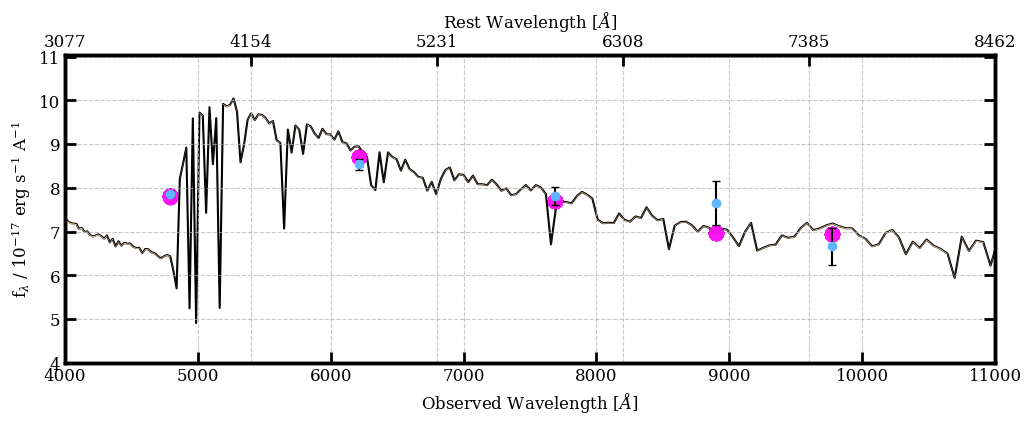

In [9]:
set_mnras_style()
fig_025_035, ax_025_035 = plot_spectrum_posterior(fit_result_025_035, standard_deviation=Flux_SD_025_035, show=True, xlim=(4.0*10**3, 1.1*10**4), ylim=(4, 11.05))


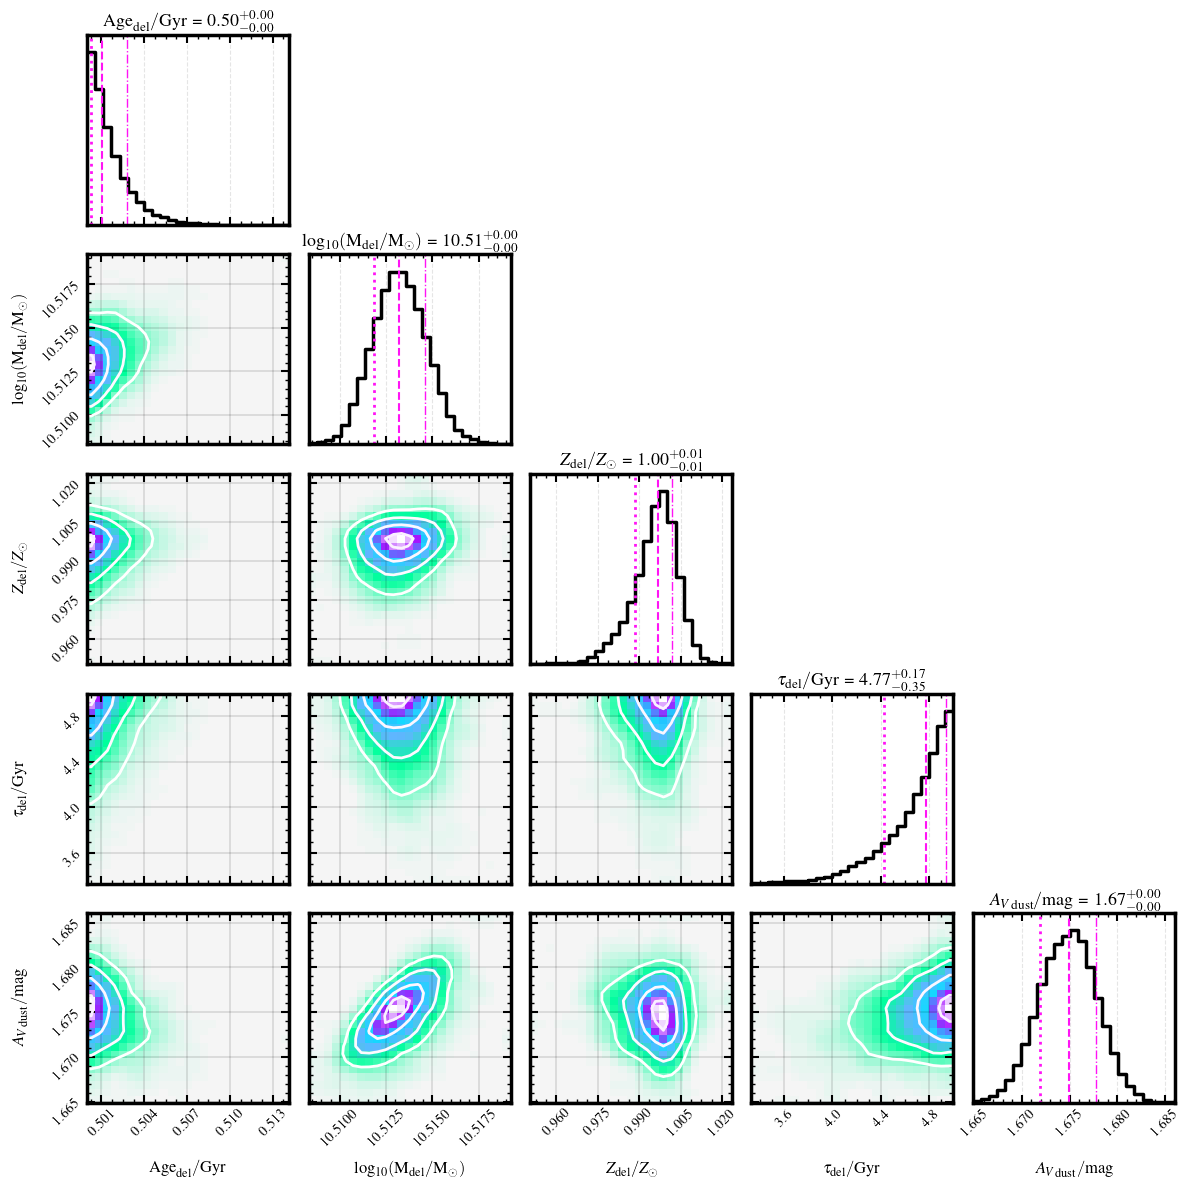

In [10]:
# Set MNRAS style first
set_mnras_style()

# Create and customize corner plot
fig_corner_025_035 = fit_result_025_035.plot_corner(save=False, show=False)
fig_corner_025_035 = customize_corner_plot(fig_corner_025_035)
# Extract figure if tuple
if isinstance(fig_corner_025_035, tuple):
    fig_corner_025_035 = fig_corner_025_035[0]
plt.show()

In [ ]:
fit_result_035_045, galaxy_obj_035_045 = run_bagpipes_fit_dynesty_fixed(
    flux_array=Flux_035_045,
    flux_err_array=Flux_SD_035_045,
    filter_response_files=hsc_filter_files,
    galaxy_id="Redshift_035_045_n=400",
    redshift=0.4,
    run_name="hsc_test_fit",
    n_live=400
)
    

BAGPIPES AGN Host Galaxy SED Fitting (Parameter-Fixed Version)
✓ dynesty is available - excellent nested sampling alternative to MultiNest

Creating BAGPIPES-compatible filter files...
Created BAGPIPES filter file: bagpipes_filters/hsc_g.filt
Created BAGPIPES filter file: bagpipes_filters/hsc_r.filt
Created BAGPIPES filter file: bagpipes_filters/hsc_i.filt
Created BAGPIPES filter file: bagpipes_filters/hsc_z.filt
Created BAGPIPES filter file: bagpipes_filters/hsc_y.filt
Successfully created 5 filter files
Creating data loader function...
Testing data loader...
Data loader returning photometry with shape: (5, 2)
Data type: float64
Sample values: [[2.53252318e+01 4.78590042e-02]
 [7.31907295e+01 1.20927364e-01]]
✓ Data loader test successful
  Photometry shape: (5, 2)

Photometric data summary:
-----------------------------------
hsc_g     :    25.33 ±   0.05 μJy (S/N: 529.2)
hsc_i     :    73.19 ±   0.12 μJy (S/N: 605.2)
hsc_r     :    50.57 ±   0.06 μJy (S/N: 899.9)
hsc_y     :   103.3

In [ ]:
set_mnras_style()
fig_035_045, ax_035_045 = plot_spectrum_posterior(fit_result_035_045, standard_deviation=Flux_SD_035_045, show=True, xlim=(4.0*10**3, 1.1*10**4), ylim=(0, 11.05))


In [ ]:
# Set MNRAS style first
set_mnras_style()

# Create and customize corner plot
fig_corner_035_045 = fit_result_035_045.plot_corner(save=False, show=False)
fig_corner_035_045 = customize_corner_plot(fig_corner_035_045)
# Extract figure if tuple
if isinstance(fig_corner_035_045, tuple):
    fig_corner_035_045 = fig_corner_035_045[0]
plt.show()

In [ ]:
fit_result_045_055, galaxy_obj_045_055 = run_bagpipes_fit_dynesty_fixed(
    flux_array=Flux_045_055,
    flux_err_array=Flux_SD_045_055,
    filter_response_files=hsc_filter_files,
    galaxy_id="Redshift_045_055_n=400",
    redshift=0.5,
    run_name="hsc_test_fit",
    n_live=400
)
    

In [ ]:
set_mnras_style()
fig_045_055, ax_045_055 = plot_spectrum_posterior(fit_result_045_055, standard_deviation=Flux_SD_045_055, show=True, xlim=(4.0*10**3, 1.1*10**4), ylim=(0, 11.05))


In [ ]:
# Set MNRAS style first
set_mnras_style()

# Create and customize corner plot
fig_corner_045_055 = fit_result_045_055.plot_corner(save=False, show=False)
fig_corner_045_055 = customize_corner_plot(fig_corner_045_055)
# Extract figure if tuple
if isinstance(fig_corner_045_055, tuple):
    fig_corner_045_055 = fig_corner_045_055[0]
plt.show()

In [ ]:
fit_result_055_065, galaxy_obj_055_065 = run_bagpipes_fit_dynesty_fixed(
    flux_array=Flux_055_065,
    flux_err_array=Flux_SD_055_065,
    filter_response_files=hsc_filter_files,
    galaxy_id="Redshift_055_065_n=400",
    redshift=0.6,
    run_name="hsc_test_fit",
    n_live=400
)
    

In [ ]:
set_mnras_style()
fig_055_065, ax_055_065 = plot_spectrum_posterior(fit_result_055_065, standard_deviation=Flux_SD_055_065, show=True, xlim=(4.0*10**3, 1.1*10**4), ylim=(0, 11.05))


In [ ]:
# Set MNRAS style first
set_mnras_style()

# Create and customize corner plot
fig_corner_055_065 = fit_result_055_065.plot_corner(save=False, show=False)
fig_corner_055_065 = customize_corner_plot(fig_corner_055_065)
# Extract figure if tuple
if isinstance(fig_corner_055_065, tuple):
    fig_corner_055_065 = fig_corner_055_065[0]
plt.show()

In [ ]:
fit_result_065_075, galaxy_obj_065_075 = run_bagpipes_fit_dynesty_fixed(
    flux_array=Flux_065_075,
    flux_err_array=Flux_SD_065_075,
    filter_response_files=hsc_filter_files,
    galaxy_id="Redshift_065_075_n=400",
    redshift=0.7,
    run_name="hsc_test_fit",
    n_live=400
)
    

In [ ]:
set_mnras_style()
fig_065_075, ax_065_075 = plot_spectrum_posterior(fit_result_065_075, standard_deviation=Flux_SD_065_075, show=True, xlim=(4.0*10**3, 1.1*10**4), ylim=(0, 11.05))


In [ ]:
# Set MNRAS style first
set_mnras_style()

# Create and customize corner plot
fig_corner_065_075 = fit_result_065_075.plot_corner(save=False, show=False)
fig_corner_065_075 = customize_corner_plot(fig_corner_065_075)
# Extract figure if tuple
if isinstance(fig_corner_065_075, tuple):
    fig_corner_065_075 = fig_corner_065_075[0]
plt.show()

In [ ]:
firesult_075_085, galaxy_obj_075_085 = run_bagpipes_fit_dynesty_fixed(
    flux_array=Flux_075_085,
    flux_err_array=Flux_SD_075_085,
    filter_response_files=hsc_filter_files,
    galaxy_id="Redshift_075_085_n=400",
    redshift=0.8,
    run_name="hsc_test_fit",
    n_live=400
)
    

In [ ]:
set_mnras_style()
fig_075_085, ax_075_085 = plot_spectrum_posterior(fit_result_075_085, standard_deviation=Flux_SD_075_085, show=True, xlim=(4.0*10**3, 1.1*10**4), ylim=(0, 11.05))


In [ ]:
# Set MNRAS style first
set_mnras_style()

# Create and customize corner plot
fig_corner_075_085 = fit_result_075_085.plot_corner(save=False, show=False)
fig_corner_075_085 = customize_corner_plot(fig_corner_075_085)
# Extract figure if tuple
if isinstance(fig_corner_075_085, tuple):
    fig_corner_075_085 = fig_corner_075_085[0]
plt.show()

In [ ]:
firesult_085_096, galaxy_obj_085_096 = run_bagpipes_fit_dynesty_fixed(
    flux_array=Flux_085_096,
    flux_err_array=Flux_SD_085_096,
    filter_response_files=hsc_filter_files,
    galaxy_id="Redshift_085_096_n=400",
    redshift=0.905,
    run_name="hsc_test_fit",
    n_live=400
)
    

In [ ]:
set_mnras_style()
fig_085_096, ax_085_096 = plot_spectrum_posterior(fit_result_085_096, standard_deviation=Flux_SD_085_096, show=True, xlim=(4.0*10**3, 1.1*10**4), ylim=(0, 11.05))


In [ ]:
# Set MNRAS style first
set_mnras_style()

# Create and customize corner plot
fig_corner_085_096 = fit_result_085_096.plot_corner(save=False, show=False)
fig_corner_085_096 = customize_corner_plot(fig_corner_085_096)
# Extract figure if tuple
if isinstance(fig_corner_085_096, tuple):
    fig_corner_085_096 = fig_corner_085_096[0]
plt.show()

In [ ]:
set_mnras_style()

# Create and customize SFH plot
fig_sfh = fit_result_025_035.plot_sfh_posterior(save=False, show=False)
fig_sfh = customize_sfh_plot(fig_sfh)
# Extract figure if tuple
if isinstance(fig_sfh, tuple):
    fig_sfh = fig_sfh[0]

plt.ylim(-10, 130)

plt.show()